In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def linear_model(x, m, c):
    return m*x + c

## Generate data with Gaussian noise

\begin{align}
y = f(x) + n
\end{align}

$\{y_i, x_i\}$. $n$ is a Gaussian.

In [3]:
injection_parameters = dict(m=0.8, c=2)

In [4]:
num_points = 100
x = np.linspace(-4, 4, num_points)

In [5]:
sigma = 0.6

In [6]:
data = linear_model(x, **injection_parameters) + np.random.normal(0, sigma, x.size)

Text(0, 0.5, 'y')

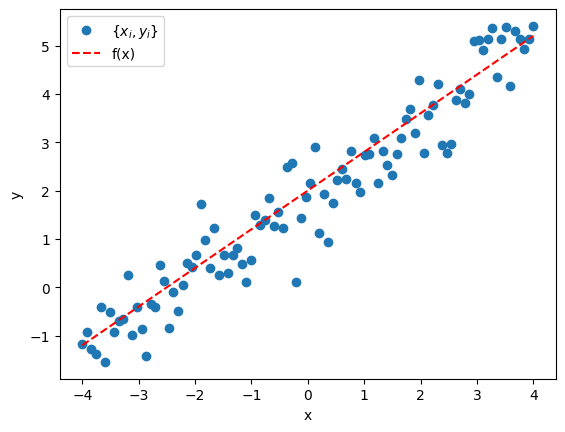

In [7]:
fig, ax = plt.subplots()
ax.plot(x, data, 'o', label='$\\{x_i, y_i\\}$')
ax.plot(x, linear_model(x, **injection_parameters), '--r', label='f(x)')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

In [8]:
import bilby
from bilby.core.prior import Uniform

## Prior for parameters

In [9]:
priors = dict()

priors['m'] = Uniform(-3, 3, name='m', latex_label='m')
priors['c'] = Uniform(-3, 3, name='c', latex_label='c')

# Train embedding space first

The aim is to make the network be agnostic to shift in the intercept. Train embedding space to cluster shifts in intercept value.

In [10]:
from IPython.display import clear_output
from time import sleep

def live_plot_samples(samples, truth):
    clear_output(wait=True)
    sleep(1)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.16, 0.5, 0.84],
        show_titles=True, labels=["m", "c"],
        truth=truth
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")

In [11]:
def get_data(m=None, c=None, num_points=1):
    """Sample m, c and return a batch of data with noise"""
    m = priors['m'].sample() if m is None else m
    c = priors['c'].sample() if c is None else c
    x = np.linspace(-4, 4, num_points)
    y = m*x + c
    y += sigma*np.random.normal(size=x.size)

    return x, y, m, c

# Add augmentation

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter

In [13]:
num_simulations = 10000
theta_vals = []
data_vals = []
for ii in range(num_simulations):
    x_val, y_val, m_val, c_val = get_data(num_points=100)
    data_vals.append(y_val)
    theta_vals.append([m_val, c_val])

In [14]:
theta_vals = np.array(theta_vals)
data_vals = np.array(data_vals)

In [15]:
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # augment the data to have several shifted intercepts
        theta, data = self.augment(idx)

        return (
            torch.from_numpy(theta).to(torch.float32),
            torch.from_numpy(data).to(torch.float32)
        )

    def augment(self, idx):
        repeats = 20  # just a choice, can be different
        m = theta_vals[idx][0]  # fix m value, sample c from prior
        theta_aug_vals, data_aug_vals = [], []
        for _ in range(repeats):
            x_val, y_val, m_val, c_val = get_data(m=m, c=None, num_points=num_points)
            data_aug_vals.append(y_val)
            theta_aug_vals.append([m_val, c_val])
        return np.array(theta_aug_vals), np.array(data_aug_vals)

In [16]:
dataset = DataGenerator()

In [17]:
dataset[0][1].shape

torch.Size([20, 100])

Text(0.5, 1.0, 'Augmented sample')

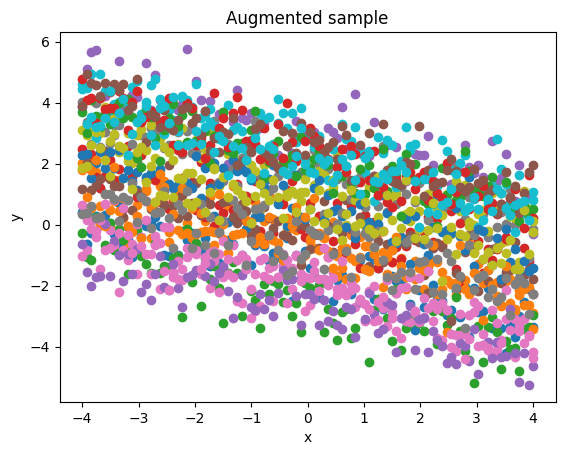

In [18]:
t, d = dataset.augment(4)

fig, ax = plt.subplots()

for (m, c), points in zip(t, d):
    ax.plot(x, points, 'o', label='$\\{x_i, y_i\\}$')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("Augmented sample")

In [19]:
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

In [20]:
train_data_loader = DataLoader(
    train_data, batch_size=20,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=20,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [21]:
for theta, data in train_data_loader:
    break

In [22]:
theta.shape, data.shape

(torch.Size([20, 20, 2]), torch.Size([20, 20, 100]))

In [23]:
theta[0]  # same "m", different "c" values

tensor([[-1.0767, -2.0267],
        [-1.0767,  2.3157],
        [-1.0767,  0.5932],
        [-1.0767,  0.0947],
        [-1.0767, -1.8766],
        [-1.0767, -1.6989],
        [-1.0767, -0.6604],
        [-1.0767,  1.5955],
        [-1.0767, -1.9244],
        [-1.0767,  0.5529],
        [-1.0767,  2.2888],
        [-1.0767,  0.9757],
        [-1.0767,  2.5781],
        [-1.0767, -2.7635],
        [-1.0767, -1.6800],
        [-1.0767, -1.7909],
        [-1.0767,  2.5472],
        [-1.0767, -1.4654],
        [-1.0767,  1.8154],
        [-1.0767,  1.2227]])

## Define similarity loss

In [24]:
# implemented from https://github.com/violatingcp/codec
class VICRegLoss(nn.Module):

    def __init__(self, lambda_param=1, mu_param=1,
                 nu_param=20, sort_tolerance=1.0,
                 sort_reg='l2'):
        
        super().__init__()
        self.lambda_param = lambda_param
        self.mu_param = mu_param
        self.nu_param = nu_param
        self.tolerance = sort_tolerance
        self.reg = sort_reg

    def forward(self, x, y):
        repr_loss = F.mse_loss(x, y)

        x = x - x.mean()
        y = y - y.mean()
        N = x.size(0)
        D = x.size(1)
        
        std_x = torch.sqrt(x.var() + 0.0001)
        std_y = torch.sqrt(y.var() + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        x = (x-x.mean())/x.std()
        y = (y-y.mean())/y.std()

        cov_x = (x.T @ x)
        cov_y = (y.T @ y)
        cov_loss = self.off_diagonal(cov_x).pow_(2).sum().div(D)
        cov_loss += self.off_diagonal(cov_y).pow_(2).sum().div(D)

        return repr_loss + cov_loss + std_loss

    def off_diagonal(self,x):
        n, m = x.shape
        assert n == m
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

In [25]:
vicreg_loss = VICRegLoss()

In [26]:
class SimilarityEmbedding(nn.Module):
    """Simple Dense embedding"""
    def __init__(self, num_hidden_layers=1, activation=torch.relu):
        super().__init__()
        self.num_hidden_layers = num_hidden_layers
        self.first_layer = nn.Linear(num_points, 10)
        self.layers = nn.ModuleList([nn.Linear(10, 10) for _ in range(num_hidden_layers)])
        self.final_layer = nn.Linear(10, 2)
        self.activation = activation

    def forward(self, x):
        x = self.first_layer(x)
        x = self.activation(x)
        for layer in self.layers:
            x = layer(x)
            x = self.activation(x)
        x = self.final_layer(x)
        return x

In [27]:
similarity_embedding = SimilarityEmbedding(num_hidden_layers=1)

optimizer = optim.Adam(similarity_embedding.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [28]:
similarity_embedding_model_path = './similarity_embedding.pt'
# torch.save(similarity_embedding.state_dict(), similarity_embedding_model_path)
similarity_embedding.load_state_dict(torch.load(similarity_embedding_model_path))

<All keys matched successfully>

In [29]:
def train_one_epoch(epoch_index, tb_writer):
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        augmented_theta, augmented_data = val
        similar_embedded_values = similarity_embedding(augmented_data)
        similar_embedded_values = similar_embedded_values.sum(axis=0)  # sum along batch dimension

        similar_embedding_loss = 0
        x = similar_embedded_values[0].reshape(1, 2)
        for ii in range(1, len(similar_embedded_values)):
            y = similar_embedded_values[ii].reshape(1, 2)
            similar_embedding_loss += vicreg_loss(x, y)

        optimizer.zero_grad()
        similar_embedding_loss.backward()
        optimizer.step()
        # Gather data and report
        running_sim_loss += similar_embedding_loss.item()
        if idx % 100 == 0:
            last_sim_loss = running_sim_loss / 100
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_sim_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('SimLoss/train', last_sim_loss, tb_x)
            running_sim_loss = 0.
    return last_sim_loss


def val_one_epoch(epoch_index, tb_writer):
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        augmented_theta_val, augmented_data_val = val
        similar_embedded_values = similarity_embedding(augmented_data_val)
        similar_embedded_values = similar_embedded_values.sum(axis=0)  # sum along batch dimension

        similar_embedding_loss = 0
        x = similar_embedded_values[0].reshape(1, 2)
        for ii in range(1, len(similar_embedded_values)):
            y = similar_embedded_values[ii].reshape(1, 2)
            similar_embedding_loss += vicreg_loss(x, y)
        
        running_sim_loss += similar_embedding_loss.item()
        if idx % 50 == 0:
            last_sim_loss = running_sim_loss / 50
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('SimLoss/val', last_sim_loss, tb_x)
            tb_writer.flush()
            running_sim_loss = 0.
    tb_writer.flush()
    return last_sim_loss

In [30]:
# writer = SummaryWriter("linear_regression_again", comment="Similarity with LR=1e-3", flush_secs=5)
# epoch_number = 0

In [31]:
# %%time
# UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
# EPOCHS = 5

# for epoch in range(EPOCHS):
#     print('EPOCH {}:'.format(epoch_number + 1))
#     # Gradient tracking
#     similarity_embedding.train(True)
#     avg_train_loss = train_one_epoch(epoch_number, writer)
    
#     # no gradient tracking, for validation
#     similarity_embedding.train(False)
#     avg_val_loss = val_one_epoch(epoch_number, writer)
    
#     print(f"Train/Val Sim Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

#     epoch_number += 1
#     scheduler.step()

## See embedded space

In [32]:
similarity_embedding.train(False)

similarity_outputs_1 = []

for idx, (theta_test, data_test) in enumerate(test_data):
    if not ((theta_test.T[0][0] < 1.1) and (theta_test.T[0][0] > 0.9)):
        continue
    with torch.no_grad():
        similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output.numpy())

similarity_outputs_2 = []

for idx, (theta_test, data_test) in enumerate(test_data):
    if not ((theta_test.T[0][0] < 0.61) and (theta_test.T[0][0] > 0.49)):
        continue
    with torch.no_grad():
        similarity_output = similarity_embedding(data_test)
    similarity_outputs_2.append(similarity_output.numpy())

In [33]:
similarity_outputs_1 = np.array(similarity_outputs_1)
similarity_outputs_2 = np.array(similarity_outputs_2)

### Similar $m$ values cluster, irrespective of $c$ values

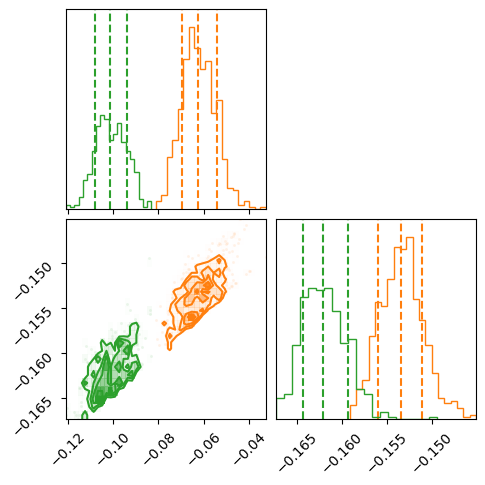

In [34]:
import corner

figure = corner.corner(
    similarity_outputs_1.reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[1], 2)),
    quantiles=[0.16, 0.5, 0.84], color="C1"
)

figure = corner.corner(
    similarity_outputs_2.reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[1], 2)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2"
)

# Freeze weights, used as embedding network in MAF

In [35]:
import corner

from nflows.distributions import StandardNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation

import nflows.utils as torchutils

In [36]:
num_transforms = 5
num_blocks = 2
hidden_features = 50

context_features = similarity_embedding(data[:,0,:])[-1].numel()

base_dist = StandardNormal([2])

transforms = []
for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
            features=2,  # 2-dim posterior
            hidden_features=hidden_features,
            context_features=context_features,
            num_blocks=num_blocks,
            activation=torch.tanh,
            use_batch_norm=False,
            use_residual_blocks=True,
            dropout_probability=0.01
        ),
        RandomPermutation(features=2)
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist, similarity_embedding)

In [37]:
flow_model_path = './flow_model_path.pt'
# torch.save(flow.state_dict(), flow_model_path)
flow.load_state_dict(torch.load(flow_model_path))

<All keys matched successfully>

# Train/Validate

In [38]:
num_augmentations = 5

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        augmented_theta, augmented_data = val

        loss = 0
        for ii in range(num_augmentations):
            theta = augmented_theta[:,ii,:]
            data = augmented_data[:,ii,:]

            flow_loss = -flow.log_prob(theta, context=data).sum()

            optimizer.zero_grad()
            flow_loss.backward()
            optimizer.step()
            
            loss += flow_loss.item()

        running_loss += loss/num_augmentations
        if idx % 100 == 0:
            last_loss = running_loss / 100 # avg loss
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('Flow Loss/train', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    return last_loss


def val_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        augmented_theta, augmented_data = val
        loss = 0
        for ii in range(num_augmentations):
            theta = augmented_theta[:,ii,:]
            data = augmented_data[:,ii,:]

            flow_loss = -flow.log_prob(theta, context=data).sum()
            loss += flow_loss.item()

        running_loss += loss/num_augmentations
        if idx % 50 == 0:
            last_loss = running_loss / 50
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('Flow Loss/val', last_loss, tb_x)

            tb_writer.flush()
            running_loss = 0.
    tb_writer.flush()
    return last_loss

In [39]:
optimizer = optim.Adam(flow.parameters(), lr=1e-3)

scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5)
scheduler_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-4)
scheduler_3 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

scheduler = optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 20])

In [40]:
# writer = SummaryWriter("linear_regression_intercept", comment="With LR=1e-3", flush_secs=5)
# epoch_number = 0

In [41]:
# %%time
# UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
# EPOCHS = 100

# for epoch in range(EPOCHS):
#     print('EPOCH {}:'.format(epoch_number + 1))
#     # Gradient tracking
#     flow.train(True)
#     # flow._embedding_net.train(False)
#     # no gradient tracking for embedding layer
#     for name, param in flow._embedding_net.named_parameters():
#         param.requires_grad = False

#     avg_train_loss = train_one_epoch(epoch_number, writer)
    
#     # no gradient tracking, for validation
#     flow.train(False)
#     avg_val_loss = val_one_epoch(epoch_number, writer)
    
#     print(f"Train/Val flow Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

#     epoch_number += 1
#     scheduler.step()

# Check on test data

In [42]:
import pandas as pd

def cast_as_bilby_result(samples, truth):
    injections = dict.fromkeys(injection_parameters)
    injections['m'] = float(truth.numpy()[0])
    injections['c'] = float(truth.numpy()[1])

    posterior = dict.fromkeys(injection_parameters)
    samples_numpy = samples.numpy()
    posterior['m'] = samples_numpy.T[0].flatten()
    posterior['c'] = samples_numpy.T[1].flatten()
    posterior = pd.DataFrame(posterior)
    
    return bilby.result.Result(
        label="test_data",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=list(injections.keys()),
        priors=priors
    )

## Posterior in $c$ is same as the prior, due to imposed symmetry

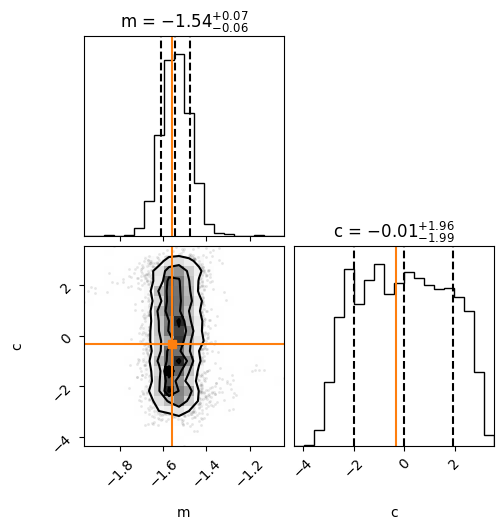

In [43]:
for idx, (theta_test, data_test) in enumerate(test_data):
    if idx == 20: break 
    with torch.no_grad():
        samples = flow.sample(5000, context=data_test[0].reshape((1, 100)))
    live_plot_samples(samples, theta_test[0])
    plt.show()

# PP plot

17:13 bilby INFO    : Key: KS-test p-value
17:13 bilby INFO    : m: 0.050951571683354735
17:13 bilby INFO    : c: 0.5858139543611638
17:13 bilby INFO    : Combined p-value: 0.1346638519597093


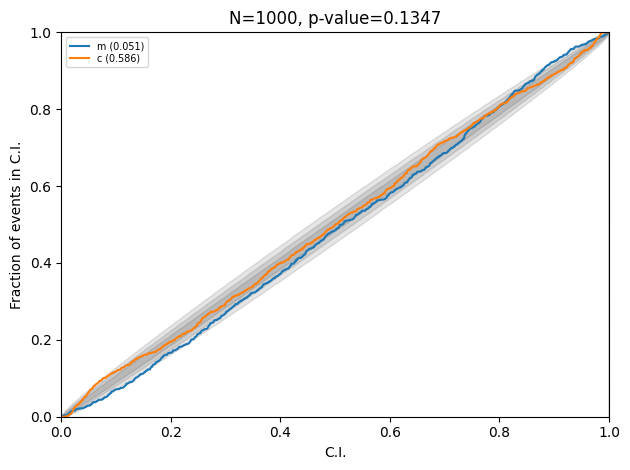

In [44]:
results = []
for idx, (theta_test, data_test) in enumerate(test_data):
    with torch.no_grad():
        samples = flow.sample(3000, context=data_test[0].reshape((1, 100)))
    results.append(
        cast_as_bilby_result(samples, theta_test[0]))

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bilby.result.make_pp_plot(results, save=False, keys=['m', 'c'])